# Import data

In [14]:
#import libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [15]:
#import data
df_dig = pd.read_csv('data/Digital_Contact.csv', sep=';')

# Explore Data

In [16]:
df_dig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cust_ID       4000 non-null   int64  
 1   Email_Clicks  4000 non-null   int64  
 2   SM_Comments   4000 non-null   int64  
 3   App_Clicks    4000 non-null   int64  
 4   SM_Likes      4000 non-null   int64  
 5   SM_Shares     3961 non-null   float64
 6   SM_Clicks     4000 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 218.9 KB


- Dtypes seem appropriate
- 4000 entries, only 39 SM_Shares have missing data

Initial Suggestions:  
- turn Cust_ID as index
- explore correlations between features: missing values in SM_Shares may not be relevant if other feature is highly correlated

In [17]:
df_dig.head()

,Cust_ID,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,4,72,1,7,7,1.0,73
1,5,15,20,1,35,15.0,16
2,6,9,7,3,73,19.0,10
3,9,67,0,2,0,1.0,101
4,10,38,0,1,9,0.0,56


In [18]:
#Cust_IDs are unique?
len(df_dig['Cust_ID'].unique())

4000

Yes, we can turn index as Cust_ID.

In [19]:
#Cust_ID as index
indices=df_dig['Cust_ID']
df_dig.set_index('Cust_ID', inplace=True)
df_dig.head(5)

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56


In [20]:
#basic statistics
df_dig.describe()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
count,4000.00000,4000.000000,4000.000000,4000.000000,3961.000000,4000.000000
mean,25.76225,8.247750,19.526500,26.957000,8.355971,30.349250
std,23.65998,8.064963,34.237945,27.742658,8.696192,32.254974
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.00000,1.000000,2.000000,4.000000,1.000000,7.000000
50%,16.00000,4.000000,4.000000,11.000000,2.000000,15.000000
75%,36.00000,15.000000,7.000000,50.000000,16.000000,60.000000
max,86.00000,24.000000,127.000000,88.000000,26.000000,102.000000


All features seem to not be normally distributed, with values of mean around 2x the median - right tail.

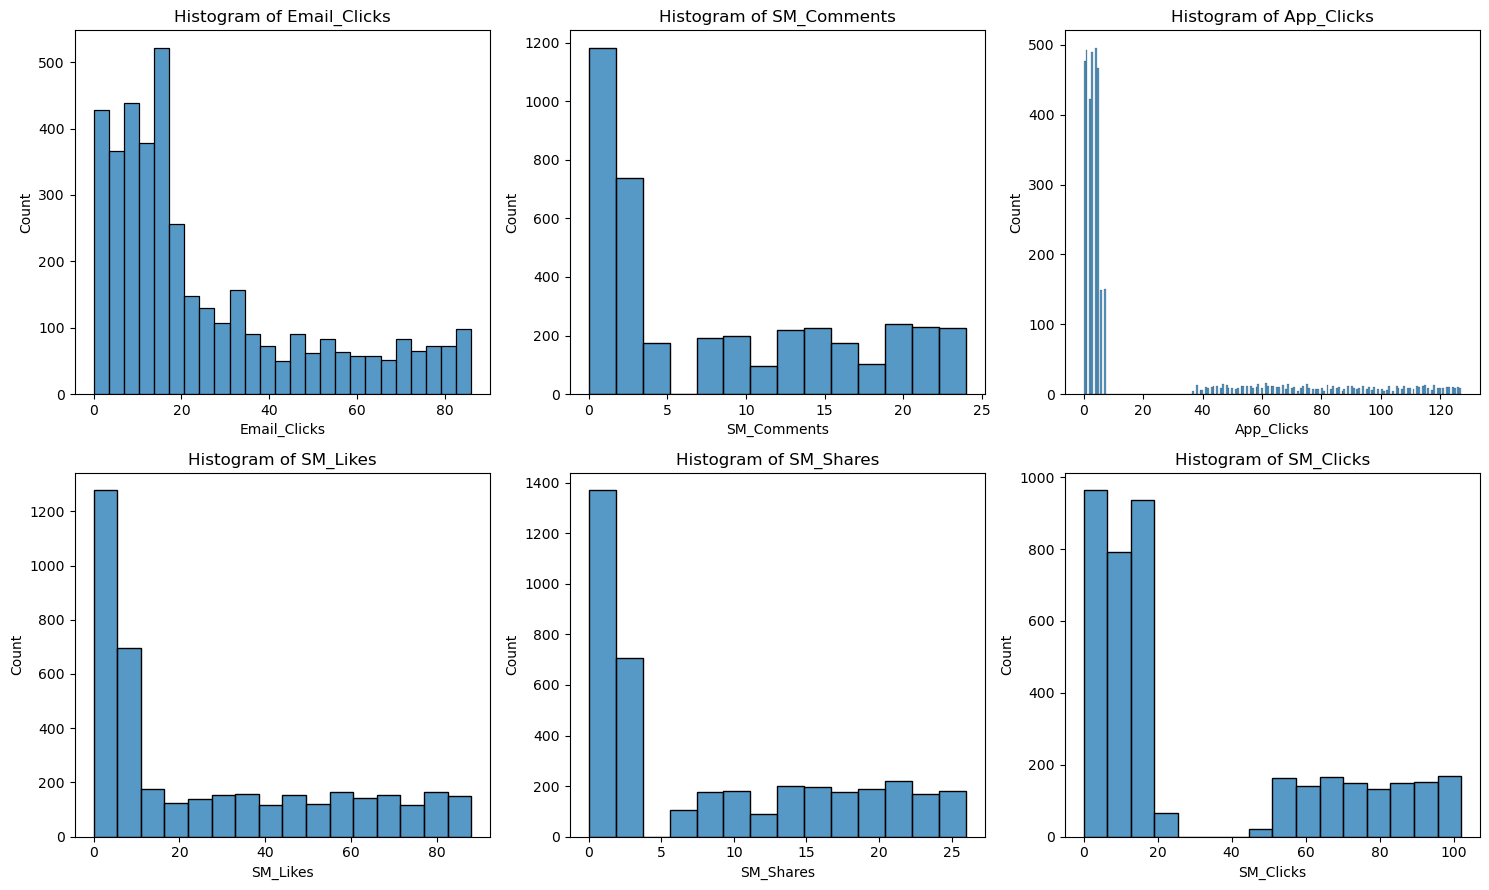

In [21]:
#look ate distribution of values
fig, axes = plt.subplots(2, 3, figsize=(15, 9))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to iterate over it

for i, column in enumerate(df_dig.columns):
        sns.histplot(df_dig[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

There is mostly an tendency for a group of people to interact very little (the majority) with social apps, and other group with constant distribution over a range of values.  

The resemblance of SM_Comments with SM_Shares is striking. We should investigate this - and all correlations.

No outliers observed.

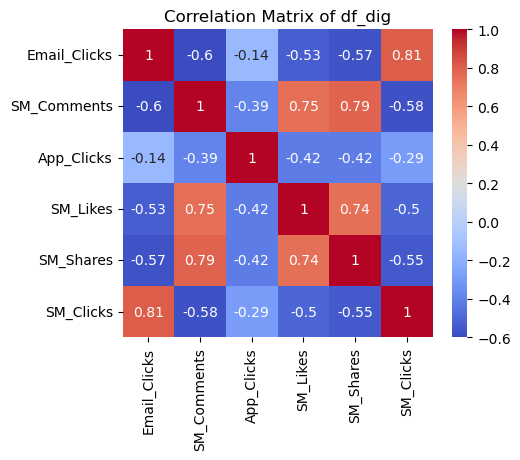

In [22]:
#correlatiomn between features
corr_matrix = df_dig.corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(5, 4))  # Set the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')#, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of df_dig')
plt.show()

There are some high correlations:
- **SM** interactions are highly correlated 0.74-0.79  
  - with a notable **exception**: moderare inverse correlation of **SM_clicks**  

    
- **Email_Clicks** is **inversely** correlated with **all** other features, except a high correlation with **SM_clicks**  

     
- **App_clicks** are generally moderately **inversely** correlated with **all** other features.   

## Fill empty values
The SM_Shares empty values represent less than 1% of the dataset's entries, and can be deleted without impact on the overall conclusions.  
However, we have strong indications, from the task's requests that the KNN usage is indeed usefull, hinting that the original data may have been deleted intentionally, and KNN may help recover it.  

Since the data is not normally distributes, neither with extended right or left tails, filling SM_Shares with the values of mean or median would result in artifacts in the data do not represent it. A KNN algorithm will be used to fill the null values in SM_Shares.

In [23]:
# Select the relevant columns for KNN Imputer
cols_para_imputer = ['SM_Shares', 'SM_Comments', 'SM_Likes', 'SM_Clicks', 'Email_Clicks', 'App_Clicks']

# Subset do DataFrame with relevant columns
df_para_imputer = df_dig[cols_para_imputer]
# Configure of imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform')  # 'distance' também é uma opção
# Apply KNN Imputer, get matrix with filled values
df_imputed = imputer.fit_transform(df_para_imputer)

# convert to df
df_imputed = pd.DataFrame(df_imputed, columns=cols_para_imputer, index=df_dig.index)

# update original df
df_dig_clean = df_dig.copy()
df_dig_clean.update(df_imputed)  # Atualiza com os valores preenchidos

# round values to int
df_dig_clean['SM_Shares'] = df_dig_clean['SM_Shares'].round().astype('int')

print('Nr. of empty values:')
df_dig_clean.isna().sum()

Nr. of empty values:


Email_Clicks    0
SM_Comments     0
App_Clicks      0
SM_Likes        0
SM_Shares       0
SM_Clicks       0
dtype: int64

All empty entries were filled.

### Fill with KNN - Pedro version, less columns - comapare

In [24]:
# Select the relevant columns for KNN Imputer
cols_para_imputer2 = ['SM_Shares', 'SM_Comments', 'SM_Likes', 'SM_Clicks']

# Subset do DataFrame with relevant columns
df_para_imputer2 = df_dig[cols_para_imputer2]
# Configure of imputer
imputer2 = KNNImputer(n_neighbors=5, weights='uniform')  # 'distance' também é uma opção
# Apply KNN Imputer, get matrix with filled values
df_imputed2 = imputer2.fit_transform(df_para_imputer2)

# convert to df
df_imputed2 = pd.DataFrame(df_imputed2, columns=cols_para_imputer2, index=df_dig.index)

# update original df
df_dig2 = df_dig.copy()
df_dig2.update(df_imputed2)  # Atualiza com os valores preenchidos

# round values to int
df_dig2['SM_Shares'] = df_dig2['SM_Shares'].round().astype('int')

print('Nr. of empty values:')
df_dig2.isna().sum()

Nr. of empty values:


Email_Clicks    0
SM_Comments     0
App_Clicks      0
SM_Likes        0
SM_Shares       0
SM_Clicks       0
dtype: int64

In [25]:
#compare both versions
(df_dig2['SM_Shares'] != df_dig_clean['SM_Shares']).sum()

16

Either using all columns, or only SM columns, the result is the same.  

# Regular clustering - kmeans and feature reduction

## Feature Reduction and Feature Scaling
one or two SM features?
(Variance Explained: Consider how much of the variance in your dataset is explained by these features. Sometimes, despite high correlation, both features might capture different aspects that are critical for clustering.)

**Two aproaches to compare for reducing dimensionality:**
1) delete two of the the correlated SM columns and keep one (Shares, Likes, and Comments)
2) put the three together into one new column (after normalization)
   - keeps all the information with less noise
   - more difficult to interpret beyond ('social interaction')


### DF Zero: df as is

In [26]:
#scale features
scaler_zero = StandardScaler()
df_dig_zero_scaled = pd.DataFrame(scaler_zero.fit_transform(df_dig_clean), columns = df_dig.columns) #applied to all columns because all are numeric
df_dig_zero_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465
1,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925
2,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966
3,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657
4,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349


### DF One: two SM columns less
The correlation between SM_Comments and SM_Shares is not high enough so that we can eliminate the SM_Shares feature.
Among Shares, Likes, and Comments, Shares has missing values and should be eliminated.  

Between Comments and Likes, Comments keeps a higher correlation with the eliminated Shares column, thus Comments will be kept as representative of the SM interactions.

In [27]:
#new option 1 df:
df_dig_one=df_dig.drop(['SM_Shares','SM_Likes'], axis=1)
df_dig_one.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Clicks
Cust_ID,,,,
4,72,1,7,73
5,15,20,1,16
6,9,7,3,10
9,67,0,2,101
10,38,0,1,56


In [28]:
#scale features
scaler_one = StandardScaler()
df_dig_one_scaled = pd.DataFrame(scaler_one.fit_transform(df_dig_one), columns = df_dig_one.columns) #applied to all columns because all are numeric
df_dig_one_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Clicks
0,1.954504,-0.898784,-0.365912,1.322465
1,-0.454928,1.457380,-0.541178,-0.444925
2,-0.708553,-0.154732,-0.482756,-0.630966
3,1.743150,-1.022792,-0.511967,2.190657
4,0.517299,-1.022792,-0.541178,0.795349


### DF Two: pull three SM columns into one
SM_shares, SM_likes, and SM_comments

#percentage of SM_Shares null values
df_dig['SM_Shares'].isnull().mean()

Less than 1% of values of SM_Shares are missing. Given the apparent existence of at least two populations, neither the mean or the median would be suitable to fill missing values. Other features do not allow a good estimation of the missing values.  
Since the missing values represent such a low proportion of the populations let's eliminate them.

In [29]:
#scale features
scaler_two = StandardScaler()
df_dig_two_scaled = pd.DataFrame(scaler_two.fit_transform(df_dig_clean), columns = df_dig_clean.columns) #applied to all columns because all are numeric
df_dig_two_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465
1,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925
2,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966
3,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657
4,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349


In [30]:
#pull Shares, Likes, and Comments into Interactions
df_dig_two_scaled['SM_interactions'] = df_dig_two_scaled[['SM_Comments', 'SM_Likes', 'SM_Shares']].mean(axis=1)
df_dig_two_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,SM_interactions
0,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465,-0.821581
1,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925,0.837246
2,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966,0.909931
3,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657,-0.947034
4,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349,-0.877239


In [31]:
df_dig_two_scaled.drop(['SM_Comments', 'SM_Likes', 'SM_Shares'], axis=1, inplace=True)
df_dig_two_scaled.head()

,Email_Clicks,App_Clicks,SM_Clicks,SM_interactions
0,1.954504,-0.365912,1.322465,-0.821581
1,-0.454928,-0.541178,-0.444925,0.837246
2,-0.708553,-0.482756,-0.630966,0.909931
3,1.743150,-0.511967,2.190657,-0.947034
4,0.517299,-0.541178,0.795349,-0.877239


## Determine Optimal Number of Clusters
Elbow Method, Silhouette Score, or the Gap Statistic

### Option Zero

In [32]:
df_dig_zero_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Email_Clicks  4000 non-null   float64
 1   SM_Comments   4000 non-null   float64
 2   App_Clicks    4000 non-null   float64
 3   SM_Likes      4000 non-null   float64
 4   SM_Shares     4000 non-null   float64
 5   SM_Clicks     4000 non-null   float64
dtypes: float64(6)
memory usage: 187.6 KB


C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1538, in _execute_child


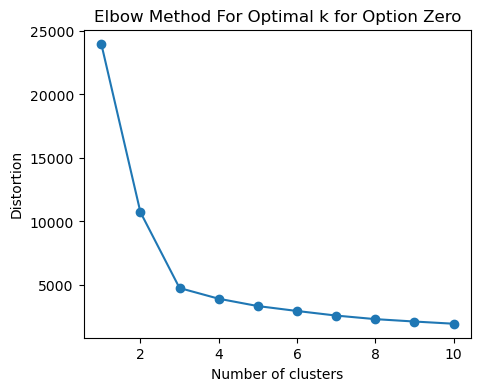

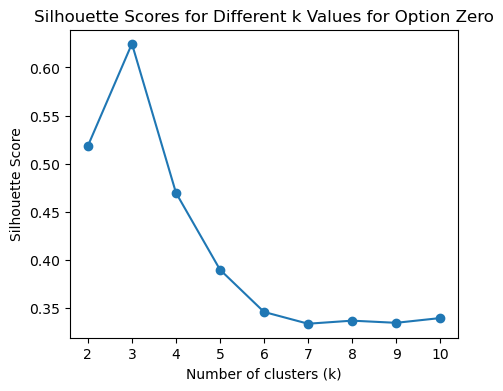

In [33]:
# Calculate distortion for a range of number of cluster
distortions_zero = [] #for elbow method

#for silhouette method
features_zero = df_dig_zero_scaled
silhouette_scores_digital_zero = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km_zero = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels_zero = km_zero.fit_predict(features_zero)  # Fit and predict simultaneously
    #calculate inertia score
    distortions_zero.append(km_zero.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features_zero, cluster_labels_zero)
        silhouette_scores_digital_zero.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_zero, marker='o')
plt.title('Elbow Method For Optimal k for Option Zero')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores_digital_zero) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores_digital_zero, marker='o')
    plt.title('Silhouette Scores for Different k Values for Option Zero')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

Best  nr of clusters is 3.

### Option One:

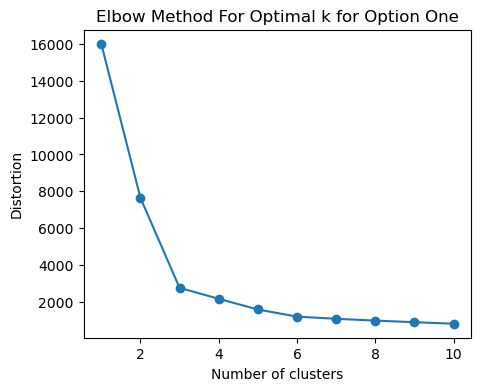

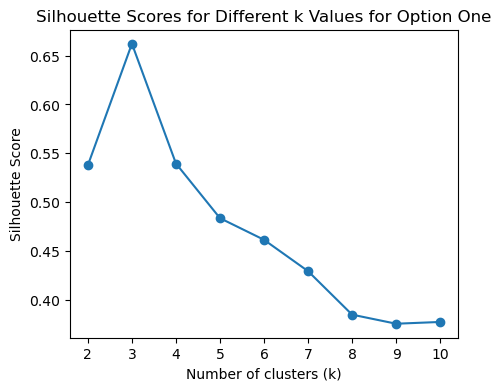

In [34]:
# Calculate distortion for a range of number of cluster
distortions_one = [] #for elbow method

#for silhouette method
features_one = df_dig_one_scaled
silhouette_scores_digital_one = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km_one = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels_one = km_one.fit_predict(features_one)  # Fit and predict simultaneously
    #calculate inertia score
    distortions_one.append(km_one.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features_one, cluster_labels_one)
        silhouette_scores_digital_one.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_one, marker='o')
plt.title('Elbow Method For Optimal k for Option One')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores_digital_one) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores_digital_one, marker='o')
    plt.title('Silhouette Scores for Different k Values for Option One')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

**3 clusters** are ideal to characterize our data. (option one)

### Option Two

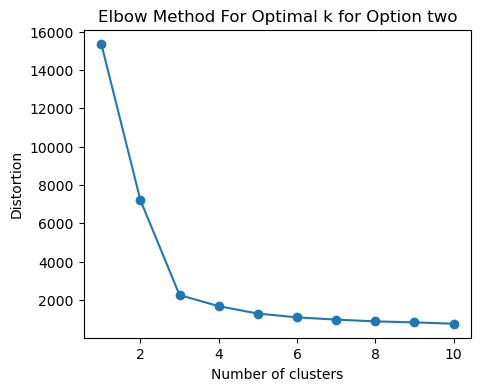

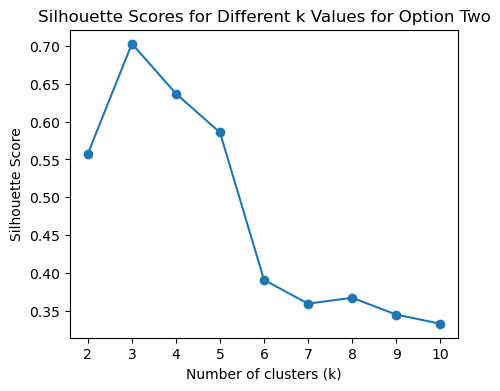

In [35]:
# Calculate distortion for a range of number of cluster
distortions_two = [] #for elbow method

#for silhouette method
features_two = df_dig_two_scaled
silhouette_scores_digital_two = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km_two = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels_two = km_two.fit_predict(features_two)  # Fit and predict simultaneously
    #calculate inertia score
    distortions_two.append(km_two.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features_two, cluster_labels_two)
        silhouette_scores_digital_two.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_two, marker='o')
plt.title('Elbow Method For Optimal k for Option two')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores_digital_two) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores_digital_two, marker='o')
    plt.title('Silhouette Scores for Different k Values for Option Two')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

**3 clusters** is also ideal for option Two.

- **Option Zero** clusters seem to represent better the data with lower distances beteween data in each cluster: 2232 vs 2762.

## K-Means Clustering

In [36]:
#Option One
n_clusters=3
km_zero_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km_zero_final.fit(df_dig_zero_scaled)
df_dig_zero_scaled['cluster'] = pd.Series(km_zero_final.predict(df_dig_zero_scaled))
df_dig_zero_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,cluster
0,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465,2
1,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925,1
2,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966,1
3,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657,2
4,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349,2


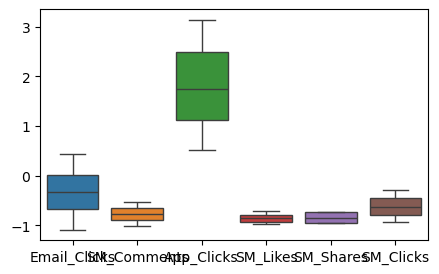

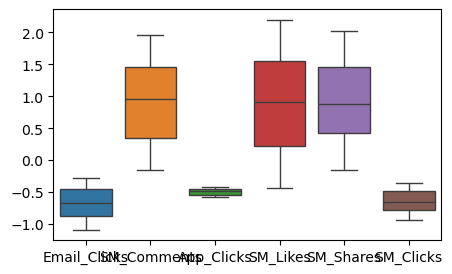

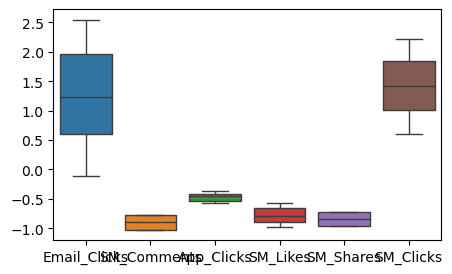

In [37]:
#look at each cluster's data
for i in range(n_clusters):
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=df_dig_zero_scaled[df_dig_zero_scaled['cluster'] == i].iloc[:,0:-1])
    plt.title('')
    plt.show()

The 3 cluster have 3 well defined behaviors:
- App users
- Pub clickers
- SM posts interaction

The 3 cluster have 3 well defined behaviors:
1) The 'high commenters', with **SM_Comments** being the only feature above average (and the other two gighly correlated, deleted features)
2) The 'social clickers', with **Email_clicks** and **SM_Clicks** above average.
3) The 'app clickers', with **App_clicks** above average.

**COLOCAR VALORES PARA CLUSTERS**

In [38]:
#create column to store scores of k=3 after kmneans
distortions = [distortions_zero[2], distortions_one[2], distortions_two[2]]
silhouette_scores = [silhouette_scores_digital_zero[1], silhouette_scores_digital_one[1], silhouette_scores_digital_two[1]] 

scores_kmeans = {'distortion': distortions, 'silhouette_score': silhouette_scores}

df_scores_kmeans = pd.DataFrame(data=scores_kmeans)
df_scores_kmeans


,distortion,silhouette_score
0,4752.322811,0.624604
1,2766.588088,0.662143
2,2254.958204,0.702768


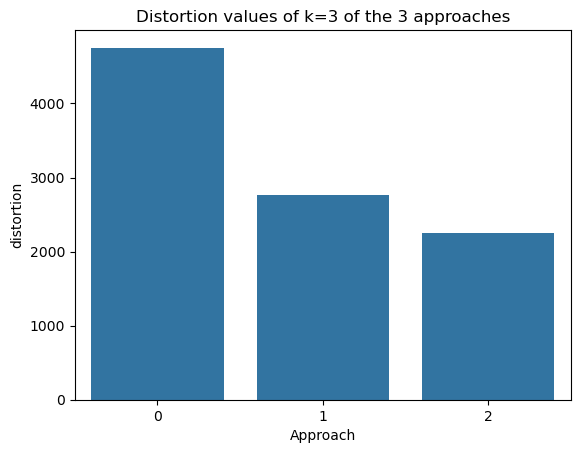

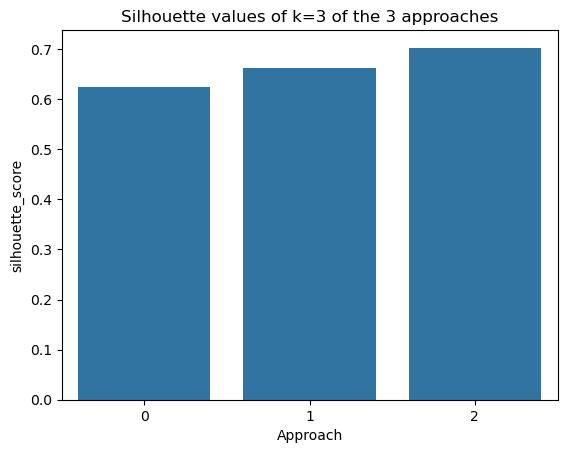

In [65]:
#graph for distortions
sns.barplot(data=df_scores_kmeans['distortion'])
plt.title('Distortion values of k=3 of the 3 approaches')
plt.xlabel('Approach')
plt.show()
#graph for silhouettes
sns.barplot(data=df_scores_kmeans['silhouette_score'])
plt.title('Silhouette values of k=3 of the 3 approaches')
plt.xlabel('Approach')
plt.show()

### Option Zero

In [41]:
#Option Zero
n_clusters=3
km_zero_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km_zero_final.fit(df_dig_zero_scaled)
df_dig_zero_scaled['cluster'] = pd.Series(km_zero_final.predict(df_dig_zero_scaled))
df_dig_zero_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,cluster
0,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465,0
1,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925,2
2,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966,2
3,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657,0
4,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349,0


In [44]:
df_dig_zero_scaled.groupby('cluster')['cluster'].count()

cluster
0    1243
1     854
2    1903
Name: cluster, dtype: int64

Cluster 0


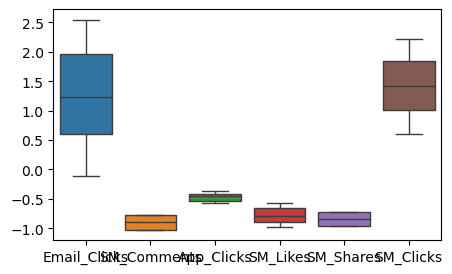

Cluster 1


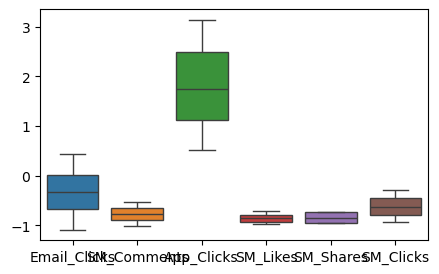

Cluster 2


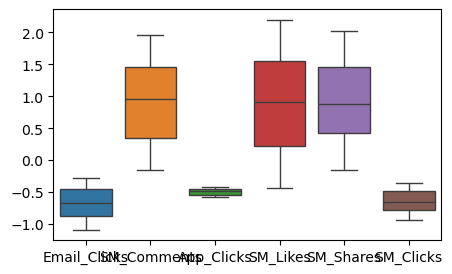

In [42]:
#look at each cluster's data
for i in range(n_clusters):
    print(f'Cluster {i}')
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=df_dig_zero_scaled[df_dig_zero_scaled['cluster'] == i].iloc[:,0:-1])
    plt.title('')
    plt.show()

**Exportar dados originais com clusters**

# Export files to compare to other DFs

In [70]:
#export final df with original cleaned data and a column with clusters
df_dig_two_scaled.index=indices
df_dig_two_scaled.to_csv('exported_data/df_dig_two_scaled.csv', index=True) #includes indices

#export cluster's quality measurement
df_scores_kmeans.to_csv('exported_data/df_scores_kmeans.csv', index=True) #includes indices

In [46]:
df_dig_zero_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,cluster
0,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465,0
1,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925,2
2,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966,2
3,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657,0
4,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349,0
